# import

In [1]:
import pandas as pd
from tqdm.notebook import tqdm as tqdm
import requests
from bs4 import BeautifulSoup
import re
import time
import urllib.request
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score,roc_curve, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import average_precision_score
import numpy as np
import matplotlib.pyplot as plt
from graphviz import *
from sklearn.preprocessing import LabelEncoder
import optuna.integration.xgboost as xgb_o
import optuna.integration.lightgbm as lgb_o
import scipy as sp
import lightgbm as lgb
import optuna
import sklearn
from scipy.special import comb
from itertools import combinations
import copy
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from scipy.special import comb
from itertools import permutations
import datetime
import lxml

# funcs

In [2]:
def split_data(df, test_size=0.2):
    sorted_id_list = df.sort_values("date").index.unique()
    train_id_list = sorted_id_list[: round(len(sorted_id_list) * (1 - test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list) * (1 - test_size)) :]
    train = df.loc[train_id_list]#.drop(['date'], axis=1)
    test = df.loc[test_id_list]#.drop(['date'], axis=1)
    return train, test

def load_csv(load_path):
    df = pd.read_csv(load_path, index_col=0)
    return df

def gain(return_func, x_, n_samples=100,lower=50,t_range=[0.5,3.5]):
    gain = {}
    for i in range(n_samples):
        threshold = t_range[1] * (i/n_samples) + t_range[0] *(1-i/n_samples)
        n_bets, return_rate, n_hits,std = return_func(x_, threshold)
        if n_bets > lower:
            gain[threshold] = {'return_rate':return_rate,'n_hits':n_hits,'std':std,'n_bets':n_bets}
    return pd.DataFrame(gain).T

place_dict = {
    '札幌':'01',  '函館':'02',  '福島':'03',  '新潟':'04',  '東京':'05', 
    '中山':'06',  '中京':'07',  '京都':'08',  '阪神':'09',  '小倉':'10'
}

race_type_dict = {
    '芝': '芝', 'ダ': 'ダート', '障': '障害'
}

def plot(g,label=''):
    plt.fill_between(g.index,y1 = g['return_rate'] - g['std'],y2=g['return_rate']+g['std'],alpha=0.3)
    plt.plot(g.index,g['return_rate'],label=label)
    plt.grid(True)
    
def update_data(old, new):
    """
    Parameters:
    ----------
    old : pandas.DataFrame
        古いデータ
    new : pandas.DataFrame
        新しいデータ
    """

    filtered_old = old[~old.index.isin(new.index)]
    return pd.concat([filtered_old, new])

def scrape_race_results(race_id_list, pre_race_results={}):
    race_results = pre_race_results
    for race_id in race_id_list:
        if race_id in race_results.keys():
            continue
        try:
            time.sleep(0.5)
            url = "https://db.netkeiba.com/race/" + race_id
            race_results[race_id] = pd.read_html(url)[0]
        except IndexError:
            continue
        except Exception as e:
            print(e)
            break
        except:
            break
    return race_results

def plot_importances(xgb_model, x_test):
    importances = pd.DataFrame(
    {'features' : x_test.columns, 'importances' : xgb_model.feature_importances_})
    print(importances.sort_values('importances', ascending=False)[:20])
    
def xgb_pred(x_train, y_train, x_test, y_test):
    param_dist = {'objective':'binary:logistic',
                  'n_estimators':14,
                  'use_label_encoder':False,
                 'max_depth':4,
                 'random_state':100}
    
    best_params = {'booster': 'gbtree', 
                   'objective': 'binary:logistic',
                   'use_label_encoder':False,
                   'eval_metric': 'rmse', 
                   'random_state': 100, 
                   'use_label_encoder':False,
                   'eta': 0.13449222415941048,
                   'max_depth': 3,
                   'lambda': 0.7223936363734638, 
                   'n_estimators': 14, 
                   'reg_alpha': 0.7879044553842869,
                   'reg_lambda': 0.7780344172793093,
                   'importance_type': 'gain'}
    xgb_model = xgb.XGBClassifier(**best_params)
    hr_pred = xgb_model.fit(x_train.astype(float), np.array(y_train), eval_metric='logloss').predict(x_test.astype(float))
    print("---------------------")
    y_proba_train = xgb_model.predict_proba(x_train)[:,1]
    y_proba = xgb_model.predict_proba(x_test)[:,1]
    print('AUC train:',roc_auc_score(y_train,y_proba_train))    
    print('AUC test :',roc_auc_score(y_test,y_proba))
    print(classification_report(np.array(y_test), hr_pred))
    xgb.plot_importance(xgb_model) 
    plot_importances(xgb_model, x_test)
    return xgb_model

def lgb_pred(x_train, y_train, x_test, y_test):
    param_dist = {
        'objective' : 'binary',
          'random_state':100,
                 }
    best_params = {
    'objective': 'binary',
    'random_state': 100,
    'feature_pre_filter': False,
    'lambda_l1': 4.693572572985162e-07,
    'lambda_l2': 0.8052948126650886,
    'num_leaves': 5,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9783720284106503,
    'bagging_freq': 7,
    'min_child_samples': 50
    }

    lgb_model = lgb.LGBMClassifier(**best_params)
    hr_pred = lgb_model.fit(x_train.astype(float), np.array(y_train), eval_metric='logloss').predict(x_test.astype(float))
    print("---------------------")
    y_proba_train = lgb_model.predict_proba(x_train.astype(float))[:,1]
    y_proba = lgb_model.predict_proba(x_test.astype(float))[:,1]
    print('AUC train:',roc_auc_score(y_train,y_proba_train))    
    print('AUC test :',roc_auc_score(y_test,y_proba))
    print(classification_report(np.array(y_test), hr_pred))
    plt.clf()
    lgb.plot_importance(lgb_model) 
    plot_importances(lgb_model, x_test)
    return lgb_model

def make_data(data_,test_rate=0.8,is_rus=True):
    data_ = data_.sort_values('date')
    x_ = data_.drop(['rank','date','単勝'],axis=1)
    y_ = data_['rank']

    test_rate = int(test_rate*len(x_))
    x_train, x_test = x_.iloc[:test_rate],x_.iloc[test_rate:]
    y_train, y_test = y_.iloc[:test_rate],y_.iloc[test_rate:]
    if is_rus:
        rus = RandomUnderSampler(random_state=0)
        x_resampled, y_resampled = rus.fit_resample(x_train, y_train)
        return x_resampled, y_resampled, x_test, y_test
    else:
        return x_train,y_train,x_test,y_test

def make_check_data(data_,test_rate=0.8):
    data_ = data_.sort_values('date')
    x_ = data_.drop(['rank','date'],axis=1)
    y_ = data_['rank']

    test_rate = int(test_rate*len(x_))
    x_train, x_check = x_.iloc[:test_rate],x_.iloc[test_rate:]
    y_train, y_check = y_.iloc[:test_rate],y_.iloc[test_rate:]

    return x_check,y_check



# race_id 命名規則

race_id 202105040802\
yyyy_pp_xx_xxrr\
y : year\
p : palce\
x : 謎\
r : race番号

# classes

In [44]:

class HorseResults:
    def __init__(self, horse_results):
        self.horse_results = horse_results[['日付', '着順', '賞金', '着差', '通過',
                                            '開催', '距離']]
        self.preprocessing()
        
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)
    
    @staticmethod
    def scrape(horse_id_list):
        #horse_idをkeyにしてDataFrame型を格納
        horse_results = {}
        for horse_id in tqdm(horse_id_list):
#         for horse_id in horse_id_list:
            try:
                url = 'https://db.netkeiba.com/horse/' + horse_id
                df = pd.read_html(url)[3]
                #受賞歴がある馬の場合、3番目に受賞歴テーブルが来るため、4番目のデータを取得する
                if df.columns[0]=='受賞歴':
                    df = pd.read_html(url)[4]
                df.index = [horse_id] * len(df)
                horse_results[horse_id] = df
                time.sleep(0.5)
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break

        #pd.DataFrame型にして一つのデータにまとめる        
        horse_results_df = pd.concat([horse_results[key] for key in horse_results])

        return horse_results_df
    
    
    #省略
        
    def preprocessing(self):
        df = self.horse_results.copy()

        # 着順に数字以外の文字列が含まれているものを取り除く
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['着順'] = df['着順'].astype(int)

        df["date"] = pd.to_datetime(df["日付"])
        df.drop(['日付'], axis=1, inplace=True)
        
        #賞金のNaNを0で埋める
        df['賞金'].fillna(0, inplace=True)
        
        #1着の着差を0にする
        df['着差'] = df['着差'].map(lambda x: 0 if x<0 else x)
        
        #レース展開データ
        #n=1: 最初のコーナー位置, n=4: 最終コーナー位置
        def corner(x, n):
            if type(x) != str:
                return x
            elif n==4:
                return int(re.findall(r'\d+', x)[-1])
            elif n==1:
                return int(re.findall(r'\d+', x)[0])
        df['first_corner'] = df['通過'].map(lambda x: corner(x, 1))
        df['final_corner'] = df['通過'].map(lambda x: corner(x, 4))
        
        df['final_to_rank'] = df['final_corner'] - df['着順']
        df['first_to_rank'] = df['first_corner'] - df['着順']
        df['first_to_final'] = df['first_corner'] - df['final_corner']
        
        #開催場所
        df['開催'] = df['開催'].str.extract(r'(\D+)')[0].map(place_dict).fillna('11')
        #race_type
        df['race_type'] = df['距離'].str.extract(r'(\D+)')[0].map(race_type_dict)
        #距離
        df['course_len'] = df['距離'].str.extract(r'(\d+)').astype(int) // 100
        df.drop(['距離'], axis=1, inplace=True)
        
        #インデックス名を与える
        df.index.name = 'horse_id'
    
        self.horse_results = df
        self.target_list = ['着順', '賞金', '着差', 'first_corner',
                            'first_to_rank', 'first_to_final','final_to_rank']
        
        
    def average(self, horse_id_list, date, n_samples='all'):
        target_df = self.horse_results.query('index in @horse_id_list')
        
        #過去何走分取り出すか指定
        if n_samples == 'all':
            filtered_df = target_df[target_df['date'] < date]
        elif n_samples > 0:
            filtered_df = target_df[target_df['date'] < date].\
                sort_values('date', ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception('n_samples must be >0')
          
        self.average_dict = {}
        self.average_dict['non_category'] = filtered_df.groupby(level=0)[self.target_list]\
            .mean().add_suffix('_{}R'.format(n_samples))
        for column in ['course_len', 'race_type', '開催']:
            self.average_dict[column] = filtered_df.groupby(['horse_id', column])\
                [self.target_list].mean().add_suffix('_{}_{}R'.format(column, n_samples))

    
    def merge(self, results, date, n_samples='all'):
        df = results[results['date']==date]
        horse_id_list = df['horse_id']
        self.average(horse_id_list, date, n_samples)
        merged_df = df.merge(self.average_dict['non_category'], left_on='horse_id',
                             right_index=True, how='left')
        for column in ['course_len','race_type', '開催']:
            merged_df = merged_df.merge(self.average_dict[column], 
                                        left_on=['horse_id', column],
                                        right_index=True, how='left')
        return merged_df
    
    def merge_all(self, results, n_samples='all'):
        date_list = results['date'].unique()
        merged_df = pd.concat(
            [self.merge(results, date, n_samples) for date in tqdm(date_list)]
        )
        return merged_df

class Return:

    def __init__(self, return_tables):
        self.return_tables = return_tables
    
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)

    @staticmethod
    def scrape(race_id_list):
        """
        払い戻し表データをスクレイピングする関数

        Parameters:
        ----------
        race_id_list : list
            レースIDのリスト

        Returns:
        ----------
        return_tables_df : pandas.DataFrame
            全払い戻し表データをまとめてDataFrame型にしたもの
        """

        return_tables = {}
        for race_id in tqdm(race_id_list):
            try:
                url = "https://db.netkeiba.com/race/" + race_id

                #普通にスクレイピングすると複勝やワイドなどが区切られないで繋がってしまう。
                #そのため、改行コードを文字列brに変換して後でsplitする
                f = urllib.request.urlopen(url)
                html = f.read()
                html = html.replace(b'<br />', b'br')
                dfs = pd.read_html(html)

                #dfsの1番目に単勝〜馬連、2番目にワイド〜三連単がある
                df = pd.concat([dfs[1], dfs[2]])

                df.index = [race_id] * len(df)
                return_tables[race_id] = df
                time.sleep(0.5)
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break

        #pd.DataFrame型にして一つのデータにまとめる
        return_tables_df = pd.concat([return_tables[key] for key in return_tables])
        return return_tables_df
    
    
    
   
    @property
    def fukusho(self):
        fukusho = self.return_tables[self.return_tables[0]=='複勝'][[1,2]]
        wins = fukusho[1].str.split('br', expand=True)[[0,1,2]]
        
        wins.columns = ['win_0', 'win_1', 'win_2']
        returns = fukusho[2].str.split('br', expand=True)[[0,1,2]]
        returns.columns = ['return_0', 'return_1', 'return_2']
        
        df = pd.concat([wins, returns], axis=1)
        for column in df.columns:
            df[column] = df[column].str.replace(',', '')
        return df.fillna(0).astype(int)
    
    @property
    def tansho(self):
        tansho = self.return_tables[self.return_tables[0]=='単勝'][[1,2]]
        tansho.columns = ['win', 'return']
        
        for column in tansho.columns:
            tansho[column] = pd.to_numeric(tansho[column], errors='coerce')
            
        return tansho
    
    @property
    def umaren(self):
        umaren = self.return_tables[self.return_tables[0]=='馬連'][[1,2]]
        wins = umaren[1].str.split('-', expand=True)[[0,1]].add_prefix('win_')
        return_ = umaren[2].rename('return')  
        df = pd.concat([wins, return_], axis=1)        
        return df.apply(lambda x: pd.to_numeric(x, errors='coerce'))
    
    @property
    def umatan(self):
        umatan = self.return_tables[self.return_tables[0]=='馬単'][[1,2]]
        wins = umatan[1].str.split('→', expand=True)[[0,1]].add_prefix('win_')
        return_ = umatan[2].rename('return')  
        df = pd.concat([wins, return_], axis=1)        
        return df.apply(lambda x: pd.to_numeric(x, errors='coerce'))
    
    @property
    def wide(self):
        wide = self.return_tables[self.return_tables[0]=='ワイド'][[1,2]]
        wins = wide[1].str.split('br', expand=True)[[0,1,2]]
        wins = wins.stack().str.split('-', expand=True).add_prefix('win_')
        return_ = wide[2].str.split('br', expand=True)[[0,1,2]]
        return_ = return_.stack().rename('return')
        df = pd.concat([wins, return_], axis=1)
        return df.apply(lambda x: pd.to_numeric(x.str.replace(',',''), errors='coerce'))
    
    @property
    def sanrentan(self):
        rentan = self.return_tables[self.return_tables[0]=='三連単'][[1,2]]
        wins = rentan[1].str.split('→', expand=True)[[0,1,2]].add_prefix('win_')
        return_ = rentan[2].rename('return')
        df = pd.concat([wins, return_], axis=1) 
        return df.apply(lambda x: pd.to_numeric(x, errors='coerce'))
    
    @property
    def sanrenpuku(self):
        renpuku = self.return_tables[self.return_tables[0]=='三連複'][[1,2]]
        wins = renpuku[1].str.split('-', expand=True)[[0,1,2]].add_prefix('win_')
        return_ = renpuku[2].rename('return')
        df = pd.concat([wins, return_], axis=1) 
        return df.apply(lambda x: pd.to_numeric(x, errors='coerce'))
    
class ModelEvaluator:

    
    def __init__(self, model, return_tables):
        self.model = model
        self.rt = Return(return_tables)
        self.fukusho = self.rt.fukusho
        self.tansho = self.rt.tansho
        self.umaren = self.rt.umaren
        self.umatan = self.rt.umatan
        self.wide = self.rt.wide
        self.sanrenpuku = self.rt.sanrenpuku
        self.sanrentan = self.rt.sanrentan

    
    #3着以内に入る確率を予測
    def predict_proba(self, X, train=True, std=True, minmax=False):
        if train:
            proba = pd.Series(
                self.model.predict_proba(X.drop(['単勝'], axis=1))[:, 1], index=X.index
            )
        else:
            proba = pd.Series(
                self.model.predict_proba(X, axis=1)[:, 1], index=X.index
            )
        if std:
            #レース内で標準化して、相対評価する。「レース内偏差値」みたいなもの。
            standard_scaler = lambda x: (x - x.mean()) / x.std()
            proba = proba.groupby(level=0).transform(standard_scaler)
        if minmax:
            #データ全体を0~1にする
            proba = (proba - proba.min()) / (proba.max() - proba.min())
        return proba
    
    #0か1かを予測
    def predict(self, X, threshold=0.5):
        y_pred = self.predict_proba(X)
        self.proba = y_pred
        return [0 if p<threshold else 1 for p in y_pred]
    
    def score(self, y_true, X):
        return roc_auc_score(y_true, self.predict_proba(X))
    
    def feature_importance(self, X, n_display=20):
        importances = pd.DataFrame({"features": X.columns, 
                                    "importance": self.model.feature_importances_})
        return importances.sort_values("importance", ascending=False)[:n_display]
    
    def pred_table(self, X, threshold=0.5, bet_only=True):
        pred_table = X.copy()[['馬番', '単勝']]
        pred_table['pred'] = self.predict(X, threshold)
        pred_table['score'] = self.proba
        if bet_only:
            return pred_table[pred_table['pred']==1][['馬番', '単勝', 'score','pred']]
        else:
            return pred_table[['馬番', '単勝', 'score', 'pred']]
        
    def bet(self, race_id, kind, umaban, amount):
        if kind == 'fukusho':
            rt_1R = self.fukusho.loc[race_id]
            return_ = (rt_1R[['win_0', 'win_1', 'win_2']]==umaban).values * \
                rt_1R[['return_0', 'return_1', 'return_2']].values * amount/100
            return_ = np.sum(return_)
        if kind == 'tansho':
            rt_1R = self.tansho.loc[race_id]
            return_ = (rt_1R['win']==umaban) * rt_1R['return'] * amount/100
        if kind == 'umaren':
            rt_1R = self.umaren.loc[race_id]
            return_ = (set(rt_1R[['win_0', 'win_1']]) == set(umaban)) \
                * rt_1R['return']/100 * amount
        if kind == 'umatan':
            rt_1R = self.umatan.loc[race_id]
            return_ = (list(rt_1R[['win_0', 'win_1']]) == list(umaban))\
                * rt_1R['return']/100 * amount
        if kind == 'wide':
            rt_1R = self.wide.loc[race_id]
            return_ = (rt_1R[['win_0', 'win_1']].\
                           apply(lambda x: set(x)==set(umaban), axis=1)) \
                * rt_1R['return']/100 * amount
            return_ = return_.sum()
        if kind == 'sanrentan':
            rt_1R = self.sanrentan.loc[race_id]
            return_ = (list(rt_1R[['win_0', 'win_1', 'win_2']]) == list(umaban)) * \
                rt_1R['return']/100 * amount
        if kind == 'sanrenpuku':
            rt_1R = self.sanrenpuku.loc[race_id]
            return_ = (set(rt_1R[['win_0', 'win_1', 'win_2']]) == set(umaban)) \
                * rt_1R['return']/100 * amount
        if not (return_ >= 0):
                return_ = amount
        return return_
        
    def fukusho_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_list.append(np.sum([
                self.bet(race_id, 'fukusho', umaban, 1) for umaban in preds['馬番']
            ]))
        return_rate = np.sum(return_list) / n_bets
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        n_hits = np.sum([x>0 for x in return_list])
        return n_bets, return_rate, n_hits, std
    
    def tansho_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        self.sample = pred_table
        n_bets = len(pred_table)
        
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_list.append(
                np.sum([self.bet(race_id, 'tansho', umaban, 1) for umaban in preds['馬番']])
            )
        
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    def tansho_return_proper(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_list.append(
                np.sum(preds.apply(lambda x: self.bet(
                    race_id, 'tansho', x['馬番'], 1/x['単勝']), axis=1)))
        
        bet_money = (1 / pred_table['単勝']).sum()
        
        std = np.std(return_list) * np.sqrt(len(return_list)) / bet_money
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / bet_money
        return n_bets, return_rate, n_hits, std
    
    def umaren_box(self, X, threshold=0.5, n_aite=5):
        pred_table = self.pred_table(X, threshold)
        n_bets = 0
        
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds.query('pred == 1')
            if len(preds_jiku) == 1:
                continue
            elif len(preds_jiku) >= 2:
                for umaban in combinations(preds_jiku['馬番'], 2):
                    return_ += self.bet(race_id, 'umaren', umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    def umatan_box(self, X, threshold=0.5, n_aite=5):
        pred_table = self.pred_table(X, threshold, bet_only = False)
        n_bets = 0
        
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds.query('pred == 1')
            if len(preds_jiku) == 1:
                continue   
            elif len(preds_jiku) >= 2:
                for umaban in permutations(preds_jiku['馬番'], 2):
                    return_ += self.bet(race_id, 'umatan', umaban, 1)
                    n_bets += 1
            return_list.append(return_)
        
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    def wide_box(self, X, threshold=0.5, n_aite=5):
        pred_table = self.pred_table(X, threshold, bet_only = False)
        n_bets = 0
        
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds.query('pred == 1')
            if len(preds_jiku) == 1:
                continue
            elif len(preds_jiku) >= 2:
                for umaban in combinations(preds_jiku['馬番'], 2):
                    return_ += self.bet(race_id, 'wide', umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std  
        
    def sanrentan_box(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = 0
        
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            if len(preds)<3:
                continue
            else:
                for umaban in permutations(preds['馬番'], 3):
                    return_ += self.bet(race_id, 'sanrentan', umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    def sanrenpuku_box(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = 0
        
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            if len(preds)<3:
                continue
            else:
                for umaban in combinations(preds['馬番'], 3):
                    return_ += self.bet(race_id, 'sanrenpuku', umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    def umaren_nagashi(self, X, threshold=0.5, n_aite=5):
        pred_table = self.pred_table(X, threshold, bet_only = False)
        n_bets = 0
        
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds.query('pred == 1')
            if len(preds_jiku) == 1:
                preds_aite = preds.sort_values('score', ascending = False)\
                    .iloc[1:(n_aite+1)]['馬番']
                return_ = preds_aite.map(
                    lambda x: self.bet(
                        race_id, 'umaren', [preds_jiku['馬番'].values[0], x], 1
                    )
                ).sum()
                n_bets += n_aite
                return_list.append(return_)
            elif len(preds_jiku) >= 2:
                for umaban in combinations(preds_jiku['馬番'], 2):
                    return_ += self.bet(race_id, 'umaren', umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    def umatan_nagashi(self, X, threshold=0.5, n_aite=5):
        pred_table = self.pred_table(X, threshold, bet_only = False)
        n_bets = 0
        
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds.query('pred == 1')
            if len(preds_jiku) == 1:
                preds_aite = preds.sort_values('score', ascending = False)\
                    .iloc[1:(n_aite+1)]['馬番']
                return_ = preds_aite.map(
                    lambda x: self.bet(
                        race_id, 'umatan', [preds_jiku['馬番'].values[0], x], 1
                    )
                ).sum()
                n_bets += n_aite
                
            elif len(preds_jiku) >= 2:
                for umaban in permutations(preds_jiku['馬番'], 2):
                    return_ += self.bet(race_id, 'umatan', umaban, 1)
                    n_bets += 1
            return_list.append(return_)
        
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    def wide_nagashi(self, X, threshold=0.5, n_aite=5):
        pred_table = self.pred_table(X, threshold, bet_only = False)
        n_bets = 0
        
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            return_ = 0
            preds_jiku = preds.query('pred == 1')
            if len(preds_jiku) == 1:
                preds_aite = preds.sort_values('score', ascending = False)\
                    .iloc[1:(n_aite+1)]['馬番']
                return_ = preds_aite.map(
                    lambda x: self.bet(
                        race_id, 'wide', [preds_jiku['馬番'].values[0], x], 1
                    )
                ).sum()
                n_bets += len(preds_aite)
                return_list.append(return_)
            elif len(preds_jiku) >= 2:
                for umaban in combinations(preds_jiku['馬番'], 2):
                    return_ += self.bet(race_id, 'wide', umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
    def sanrentan_nagashi(self, X, threshold = 1.5, n_aite=7):
        pred_table = self.pred_table(X, threshold, bet_only = False)
        n_bets = 0
        return_list = []
        for race_id, preds in pred_table.groupby(level=0):
            preds_jiku = preds.query('pred == 1')
            if len(preds_jiku) == 1:
                continue
            elif len(preds_jiku) == 2:
                preds_aite = preds.sort_values('score', ascending = False)\
                    .iloc[2:(n_aite+2)]['馬番']
                return_ = preds_aite.map(
                    lambda x: self.bet(
                        race_id, 'sanrentan',
                        np.append(preds_jiku['馬番'].values, x),
                        1
                    )
                ).sum()
                n_bets += len(preds_aite)
                return_list.append(return_)
            elif len(preds_jiku) >= 3:
                return_ = 0
                for umaban in permutations(preds_jiku['馬番'], 3):
                    return_ += self.bet(race_id, 'sanrentan', umaban, 1)
                    n_bets += 1
                return_list.append(return_)
        
        std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
        
        n_hits = np.sum([x>0 for x in return_list])
        return_rate = np.sum(return_list) / n_bets
        return n_bets, return_rate, n_hits, std
    
class DataProcessor:
    
    def __init__(self):
        self.data = pd.DataFrame() #raw data
        self.data_p = pd.DataFrame() #after preprocessing
        self.data_h = pd.DataFrame() #after merging horse_results
        self.data_pe = pd.DataFrame() #after merging peds
        self.data_c = pd.DataFrame() #after processing categorical features
        
    #馬の過去成績データの追加
    def merge_horse_results(self, hr, n_samples_list=[5, 9, 'all']):
        self.data_h = self.data_p.copy()
        for n_samples in n_samples_list:
            self.data_h = hr.merge_all(self.data_h, n_samples=n_samples)
        self.data_h.drop(['開催'], axis=1, inplace=True)
            
    #血統データ追加
    def merge_peds(self, peds):
        self.data_pe = \
            self.data_h.merge(peds, left_on='horse_id', right_index=True,
                                                             how='left')
        self.no_peds = self.data_pe[self.data_pe['peds_0'].isnull()]\
            ['horse_id'].unique()
        if len(self.no_peds) > 0:
            print('scrape peds at horse_id_list "no_peds"')
            
        #カテゴリ変数の処理
    def process_categorical(self, le_horse, le_jockey, results_m):
        df = self.data_pe.copy()
        
        #ラベルエンコーディング。horse_id, jockey_idを0始まりの整数に変換
        mask_horse = df['horse_id'].isin(le_horse.classes_)
        new_horse_id = df['horse_id'].mask(mask_horse).dropna().unique()
        le_horse.classes_ = np.concatenate([le_horse.classes_, new_horse_id])
        df['horse_id'] = le_horse.transform(df['horse_id'])
        mask_jockey = df['jockey_id'].isin(le_jockey.classes_)
        new_jockey_id = df['jockey_id'].mask(mask_jockey).dropna().unique()
        le_jockey.classes_ = np.concatenate([le_jockey.classes_, new_jockey_id])
        df['jockey_id'] = le_jockey.transform(df['jockey_id'])
        
        #horse_id, jockey_idをpandasのcategory型に変換
        df['horse_id'] = df['horse_id'].astype('category')
        df['jockey_id'] = df['jockey_id'].astype('category')
        
        #そのほかのカテゴリ変数をpandasのcategory型に変換してからダミー変数化
        #列を一定にするため
        weathers = results_m['weather'].unique()
        race_types = results_m['race_type'].unique()
        ground_states = results_m['ground_state'].unique()
        sexes = results_m['性'].unique()
        df['weather'] = pd.Categorical(df['weather'], weathers)
        df['race_type'] = pd.Categorical(df['race_type'], race_types)
        df['ground_state'] = pd.Categorical(df['ground_state'], ground_states)
        df['性'] = pd.Categorical(df['性'], sexes)
        df = pd.get_dummies(df, columns=['weather', 'race_type', 'ground_state', '性'])
        
        self.data_c = df    
    
class ShutubaTable(DataProcessor):
    def __init__(self, shutuba_tables):
        super(ShutubaTable, self).__init__()
        self.data = shutuba_tables
    
    @classmethod
    def scrape(cls, race_id_list, date):
        data = pd.DataFrame()
        for race_id in tqdm(race_id_list):
            url = 'https://race.netkeiba.com/race/shutuba.html?race_id=' + race_id
            df = pd.read_html(url)[0]
            df = df.T.reset_index(level=0, drop=True).T

            html = requests.get(url)
            html.encoding = "EUC-JP"
            soup = BeautifulSoup(html.text, "html.parser")

            texts = soup.find('div', attrs={'class': 'RaceData01'}).text
            texts = re.findall(r'\w+', texts)
            for text in texts:
                if 'm' in text:
                    df['course_len'] = [int(re.findall(r'\d+', text)[0])] * len(df)
                if text in ["曇", "晴", "雨", "小雨", "小雪", "雪"]:
                    df["weather"] = [text] * len(df)
                if text in ["良", "稍重", "重","稍"]:
                    df["ground_state"] = [text] * len(df)
                if '不' in text:
                    df["ground_state"] = ['不良'] * len(df)
                if '芝' in text:
                    df['race_type'] = ['芝'] * len(df)
                if '障' in text:
                    df['race_type'] = ['障害'] * len(df)
                if 'ダ' in text:
                    df['race_type'] = ['ダート'] * len(df)
            df['date'] = [date] * len(df)

            # horse_id
            horse_id_list = []
            horse_td_list = soup.find_all("td", attrs={'class': 'HorseInfo'})
            for td in horse_td_list:
                horse_id = re.findall(r'\d+', td.find('a')['href'])[0]
                horse_id_list.append(horse_id)
            # jockey_id
            jockey_id_list = []
            jockey_td_list = soup.find_all("td", attrs={'class': 'Jockey'})
            for td in jockey_td_list:
                jockey_id = re.findall(r'\d+', td.find('a')['href'])[0]
                jockey_id_list.append(jockey_id)
            df['horse_id'] = list(map(lambda x: int(x),horse_id_list)) 
            df['jockey_id'] = jockey_id_list

            df.index = [race_id] * len(df)
#             win 環境だとなぜかintに直せない.floatならつかえる
            df.index = df.index.astype(float)
            data = data.append(df)

            
        return data
                
    def preprocessing(self):
        df = self.data.copy()
        
        df["性"] = df["性齢"].map(lambda x: str(x)[0])
        df["年齢"] = df["性齢"].map(lambda x: str(x)[1:]).astype(int)

        # 馬体重を体重と体重変化に分ける
        df = df[df["馬体重(増減)"] != '--']
        df["体重"] = df["馬体重(増減)"].str.split("(", expand=True)[0].astype(int)
        df["体重変化"] = df["馬体重(増減)"].str.split("(", expand=True)[1].str[:-1].astype(int)
        
        df["date"] = pd.to_datetime(df["date"])
        
        df['枠'] = df['枠'].astype(int)
        df['馬番'] = df['馬番'].astype(int)
        df['斤量'] = df['斤量'].astype(int)
        df['開催'] = df.index.map(lambda x:str(x)[4:6])
        df['n_horse'] = df.index.map(lambda x: len(df.loc[x]))

        # 不要な列を削除
        df = df[['枠', '馬番', '斤量', 'course_len', 'weather','race_type',
        'ground_state', 'date', 'horse_id', 'jockey_id', '性', '年齢',
       '体重', '体重変化','開催','n_horse']]
        
        self.data_p = df.rename(columns={'枠': '枠番'})
        
class Results(DataProcessor):
    def __init__(self, results):
        super(Results, self).__init__()
        self.data = results
        
        
    @staticmethod
    def scrape(race_id_list):
        #race_idをkeyにしてDataFrame型を格納
        race_results = {}
        for race_id in tqdm(race_id_list):
            time.sleep(0.5)
            try:
                url = "https://db.netkeiba.com/race/" + race_id
                #メインとなるテーブルデータを取得
                df = pd.read_html(url)[0]
                html = requests.get(url)
                html.encoding = "EUC-JP"
                soup = BeautifulSoup(html.text, "html.parser")

                #天候、レースの種類、コースの長さ、馬場の状態、日付をスクレイピング
                texts = (
                    soup.find("div", attrs={"class": "data_intro"}).find_all("p")[0].text
                    + soup.find("div", attrs={"class": "data_intro"}).find_all("p")[1].text
                )
                info = re.findall(r'\w+', texts)
                for text in info:
                    if text in ["芝", "ダート"]:
                        df["race_type"] = [text] * len(df)
                    if "障" in text:
                        df["race_type"] = ["障害"] * len(df)
                    if "m" in text:
                        df["course_len"] = [int(re.findall(r"\d+", text)[0])] * len(df)
                    if text in ["良", "稍重", "重", "不良"]:
                        df["ground_state"] = [text] * len(df)
                    if text in ["曇", "晴", "雨", "小雨", "小雪", "雪"]:
                        df["weather"] = [text] * len(df)
                    if "年" in text:
                        df["date"] = [text] * len(df)

                #馬ID、騎手IDをスクレイピング
                horse_id_list = []
                horse_a_list = soup.find("table", attrs={"summary": "レース結果"}).find_all(
                    "a", attrs={"href": re.compile("^/horse")}
                )
                for a in horse_a_list:
                    horse_id = re.findall(r"\d+", a["href"])
                    horse_id_list.append(horse_id[0])
                jockey_id_list = []
                jockey_a_list = soup.find("table", attrs={"summary": "レース結果"}).find_all(
                    "a", attrs={"href": re.compile("^/jockey")}
                )
                for a in jockey_a_list:
                    jockey_id = re.findall(r"\d+", a["href"])
                    jockey_id_list.append(jockey_id[0])
                df["horse_id"] = horse_id_list
                df["jockey_id"] = jockey_id_list

                #インデックスをrace_idにする
                df.index = [race_id] * len(df)

                race_results[race_id] = df
            #存在しないrace_idを飛ばす
            except IndexError:
                continue
            #wifiの接続が切れた時などでも途中までのデータを返せるようにする
            except Exception as e:
                print(e)
                break
            #Jupyterで停止ボタンを押した時の対処
            except:
                break

        #pd.DataFrame型にして一つのデータにまとめる
        race_results_df = pd.concat([race_results[key] for key in race_results])

        return race_results_df
        
    #前処理    
    def preprocessing(self):
        df = self.data.copy()

        # 着順に数字以外の文字列が含まれているものを取り除く
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['着順'] = df['着順'].astype(int)
        df['rank'] = df['着順'].map(lambda x:1 if x<4 else 0)

        # 性齢を性と年齢に分ける
        df["性"] = df["性齢"].map(lambda x: str(x)[0])
        df["年齢"] = df["性齢"].map(lambda x: str(x)[1:]).astype(int)

        # 馬体重を体重と体重変化に分ける
        df["体重"] = df["馬体重"].str.split("(", expand=True)[0].astype(int)
        df["体重変化"] = df["馬体重"].str.split("(", expand=True)[1].str[:-1].astype(int)

        # データをint, floatに変換
        df["単勝"] = df["単勝"].astype(float)
        df["course_len"] = df["course_len"].astype(float) // 100

        # 不要な列を削除
        df.drop(["タイム", "着差", "調教師", "性齢", "馬体重", '馬名', '騎手', '人気', '着順'],
                axis=1, inplace=True)

        df["date"] = pd.to_datetime(df["date"], format="%Y年%m月%d日")
        
        #開催場所
        df['開催'] = df.index.map(lambda x:str(x)[4:6])
        df['n_horse'] = df.index.map(lambda x: len(df.loc[x]))
        
        self.data_p = df
    
    #カテゴリ変数の処理
    def process_categorical(self):
        self.le_horse = LabelEncoder().fit(self.data_pe['horse_id'])
        self.le_jockey = LabelEncoder().fit(self.data_pe['jockey_id'])
        super().process_categorical(self.le_horse, self.le_jockey, self.data_pe)
        
class Peds:

    def __init__(self, peds):
        self.peds = peds
        self.peds_e = pd.DataFrame() #after label encoding and transforming into category
    
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.concat([pd.read_pickle(path) for path in path_list])
        return cls(df)
    
    @staticmethod
    def scrape(horse_id_list):
        peds_dict = {}
        for horse_id in tqdm(horse_id_list):
#         for horse_id in horse_id_list:
            try:
                url = "https://db.netkeiba.com/horse/ped/" + horse_id
                df = pd.read_html(url)[0]

                #重複を削除して1列のSeries型データに直す
                generations = {}
                for i in reversed(range(5)):
                    generations[i] = df[i]
                    df.drop([i], axis=1, inplace=True)
                    df = df.drop_duplicates()
                ped = pd.concat([generations[i] for i in range(5)]).rename(horse_id)

                peds_dict[horse_id] = ped.reset_index(drop=True)
                time.sleep(0.5)
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break

        #列名をpeds_0, ..., peds_61にする
        peds_df = pd.concat([peds_dict[key] for key in peds_dict],
                            axis=1).T.add_prefix('peds_')

        return peds_df
    
    def encode(self):
        df = self.peds.copy()
        for column in df.columns:
            df[column] = LabelEncoder().fit_transform(df[column].fillna('Na'))
        self.peds_e = df.astype('category')


# load data

In [46]:
results = load_csv(path_win2+'results.csv')
horse_results = load_csv(path_win2+'horse_results.csv')
peds = load_csv(path_win2+'peds.csv')
return_tables = load_csv(path_win2+'return.csv')

# 学習データ作成

In [47]:
#Resultsクラスのオブジェクト作成
r = Results(results)

#前処理
r.preprocessing()

#馬の過去成績データ追加
hr = HorseResults(horse_results)
r.merge_horse_results(hr)

#血統データ追加
p = Peds(peds)
p.encode()
r.merge_peds(p.peds_e)

#カテゴリ変数の処理
r.process_categorical()


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

In [48]:
return_tables.rename(columns={'0':0,'1':1,'2':2,'3':3},inplace=True)

# 学習 & 評価

In [51]:
train, test = split_data(r.data_c,test_size=0.8)
X_train = train.drop(['rank', 'date','単勝'], axis=1)
y_train = train['rank']
X_test = test.drop(['rank', 'date'], axis=1)
y_test = test['rank']

#訓練
params = {
    'objective': 'binary',
    'random_state': 100,
    'feature_pre_filter': False,
    'lambda_l1': 0.00020915763049139397,
    'lambda_l2': 0.0004315924345758067,
    'num_leaves': 31,
    'feature_fraction': 0.7,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'min_child_samples': 100
}
lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)

#回収率シミュレーション
me2 = ModelEvaluator(lgb_clf, return_tables)


#回収率プ

---------------------
AUC train: 0.7199633756443341
AUC test : 0.7048017699168434
              precision    recall  f1-score   support

           0       0.88      0.60      0.71     13354
           1       0.33      0.70      0.45      3823

    accuracy                           0.62     17177
   macro avg       0.60      0.65      0.58     17177
weighted avg       0.75      0.62      0.65     17177

             features  importances
24    着順_race_type_5R     0.250712
10              着順_5R     0.107175
38              着順_9R     0.091379
52    着順_race_type_9R     0.074190
80  着順_race_type_allR     0.062179
17   着順_course_len_5R     0.056251
11              賞金_5R     0.054699
66            着順_allR     0.034876
31           着順_開催_5R     0.031384
81  賞金_race_type_allR     0.021636
9             n_horse     0.021075
53    賞金_race_type_9R     0.019597
4            horse_id     0.019509
5           jockey_id     0.018874
60           賞金_開催_9R     0.017991
87         着順_開催_allR     0.017

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.13449222415941048, eval_metric='rmse', gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              lambda=0.7223936363734638, learning_rate=0.134492218,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=14, n_jobs=20,
              num_parallel_tree=1, predictor='auto', random_state=100,
              reg_alpha=0.7879044553842869, reg_lambda=0.7780344172793093,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, ...)

C:\JupyterLab\resources\jlab_server\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 30528 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\JupyterLab\resources\jlab_server\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 38918 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\JupyterLab\resources\jlab_server\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 36062 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\JupyterLab\resources\jlab_server\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 37329 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\JupyterLab\resources\jlab_server\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 24046 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\JupyterLab\resources\jlab_server\lib\site-packages\matplotlib\backe

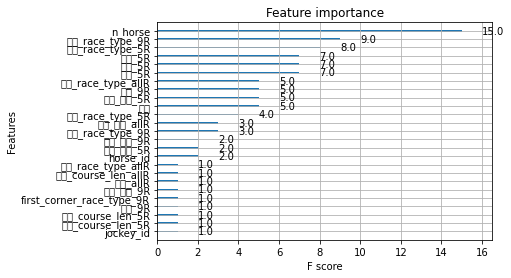

In [70]:
x_train,y_train,x_test,y_test= make_data(r.data_c)
xgb_pred(x_train,y_train,x_test,y_test)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=4.693572572985162e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.693572572985162e-07
[LightGBM] [Warning] bagging_fraction is set=0.9783720284106503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9783720284106503
[LightGBM] [Warning] lambda_l2 is set=0.8052948126650886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8052948126650886
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
---------------------
AUC train: 0.7426315269375308
AUC test : 0.7148138179439447
              precision    recall  f1-score   support

           0       0.88      0.61      0.72     13354
           1       0.34      0.71      0.46      3823

    accuracy                           0.63     17177
   macro avg       0.61      0.66      0.59     

LGBMClassifier(bagging_fraction=0.9783720284106503, bagging_freq=7,
               feature_fraction=0.8, feature_pre_filter=False,
               lambda_l1=4.693572572985162e-07, lambda_l2=0.8052948126650886,
               min_child_samples=50, num_leaves=5, objective='binary',
               random_state=100)

<Figure size 432x288 with 0 Axes>

C:\JupyterLab\resources\jlab_server\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 39340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\JupyterLab\resources\jlab_server\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 30058 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\JupyterLab\resources\jlab_server\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 30528 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\JupyterLab\resources\jlab_server\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 24046 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\JupyterLab\resources\jlab_server\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 38283 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\JupyterLab\resources\jlab_server\lib\site-packages\matplotlib\backe

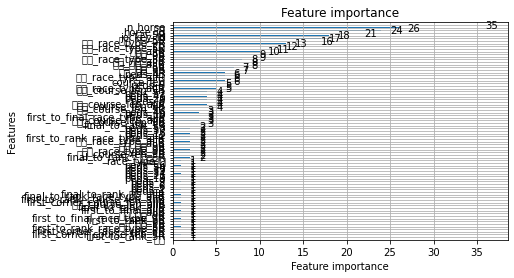

In [71]:
x_train,y_train,x_test,y_test= make_data(r.data_c)
lgb_pred(x_train,y_train,x_test,y_test)

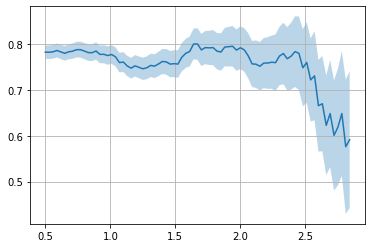

In [284]:
gain_optuna = gain(me2.tansho_return_proper, X_test)
plot(gain_optuna)

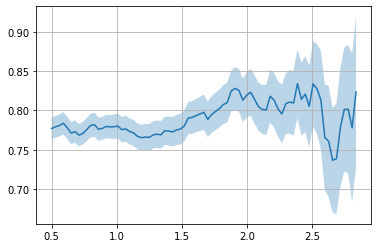

In [291]:
gain_optuna = gain(me2.fukusho_return, X_test)
plot(gain_optuna)

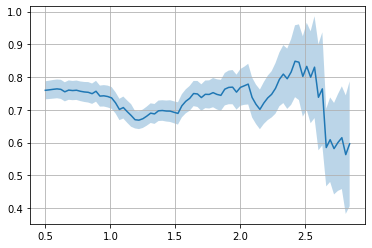

In [292]:
gain_optuna = gain(me2.tansho_return, X_test)
plot(gain_optuna)

/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-296-e749af09bc8f>:401: RuntimeWarning: invalid value encountered in double_scalars
  return_rate = np.sum(return_list) / n_bets


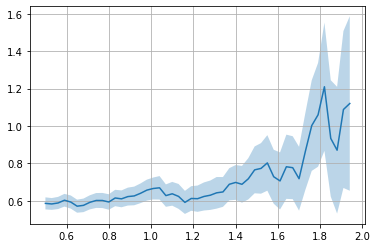

In [299]:
gain_optuna = gain(me2.umaren_box, X_test)
plot(gain_optuna)

<ipython-input-305-e749af09bc8f>:420: RuntimeWarning: invalid value encountered in double_scalars
  std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
<ipython-input-305-e749af09bc8f>:423: RuntimeWarning: invalid value encountered in long_scalars
  return_rate = np.sum(return_list) / n_bets


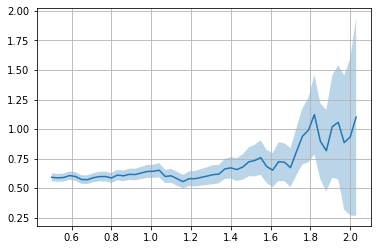

In [307]:
gain_optuna = gain(me2.umatan_box, X_test)
plot(gain_optuna)

/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-305-e749af09bc8f>:445: RuntimeWarning: invalid value encountered in double_scalars
  return_rate = np.sum(return_list) / n_bets


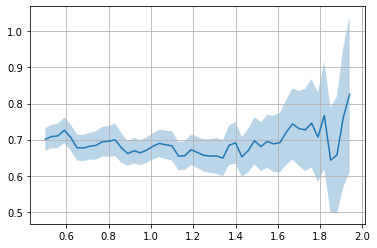

In [308]:
gain_optuna = gain(me2.wide_box, X_test)
plot(gain_optuna)

/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-305-e749af09bc8f>:466: RuntimeWarning: invalid value encountered in double_scalars
  return_rate = np.sum(return_list) / n_bets


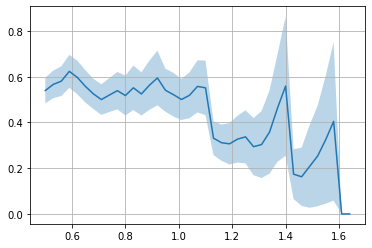

In [309]:
gain_optuna = gain(me2.sanrentan_box, X_test)
plot(gain_optuna)

/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-305-e749af09bc8f>:487: RuntimeWarning: invalid value encountered in double_scalars
  return_rate = np.sum(return_list) / n_bets


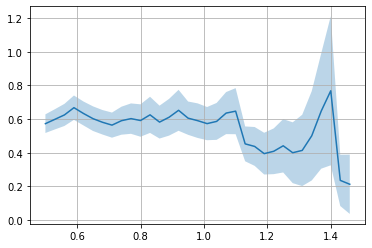

In [311]:
gain_optuna = gain(me2.sanrenpuku_box, X_test)
plot(gain_optuna)

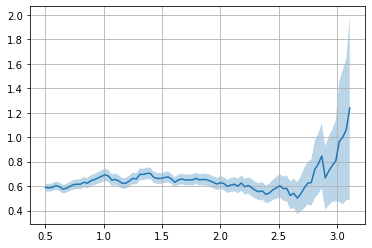

In [312]:
gain_optuna = gain(me2.umaren_nagashi, X_test)
plot(gain_optuna)

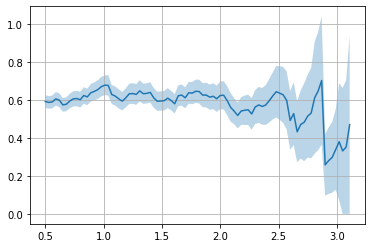

In [313]:
gain_optuna = gain(me2.umatan_nagashi, X_test)
plot(gain_optuna)

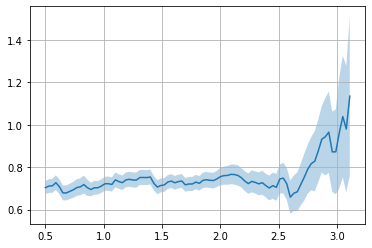

In [314]:
gain_optuna = gain(me2.wide_nagashi, X_test)
plot(gain_optuna)

/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-305-e749af09bc8f>:610: RuntimeWarning: invalid value encountered in double_scalars
  return_rate = np.sum(return_list) / n_bets


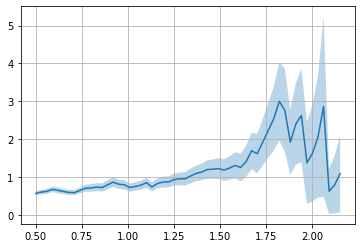

In [315]:
gain_optuna = gain(me2.sanrentan_nagashi, X_test)
plot(gain_optuna)

# 予測

新馬はやめた方が良さそう

In [83]:
race_id = 202109050411
data =  ShutubaTable.scrape([str(race_id)], '2021/11/14')

  0%|          | 0/1 [00:00<?, ?it/s]

In [84]:
# race_id_list = ['2020010106{}'.format(str(i).zfill(2)) for i in range(1,13)]
st = ShutubaTable(data)


#前処理
st.preprocessing()

#馬の過去成績データ追加
st.merge_horse_results(hr)

#血統データ追加
st.merge_peds(p.peds_e)

#カテゴリ変数の処理
st.process_categorical(r.le_horse, r.le_jockey, r.data_pe)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [85]:
# return_tables = pd.read_pickle('return_tables.pickle')
return_tables.rename(columns={'0':0,'1':1,'2':2,'3':3},inplace=True)
me_st = ModelEvaluator(lgb_clf, return_tables)

#予測
scores = me_st.predict_proba(st.data_c.drop(['date'],axis=1),train=False)
pred = st.data_c[['馬番']].copy()
pred['scores'] = scores
pred.loc[race_id].sort_values('scores',ascending=False)


[LightGBM] [Warning] Unknown parameter: axis


,馬番,scores
2.021091e+11,1,1.990943
2.021091e+11,2,1.642466
2.021091e+11,3,0.690102
2.021091e+11,12,0.627865
2.021091e+11,10,0.596286
2.021091e+11,4,0.589192
2.021091e+11,8,0.350938
2.021091e+11,6,0.132527
2.021091e+11,16,-0.100690
2.021091e+11,5,-0.110488


# 2020年のデータと2021年のデータをconcat

In [206]:
return_tables = update_data(return_tables_old, return_tables_new)

results = update_data(results_old, results_new)

peds = update_data(peds_old, peds_new)

horse_results = update_data(horse_results_old,horse_results_new)

save_path = '/Users/rince/Desktop/Horse/Data/20_21/return_tables.csv'
return_tables.to_csv(save_path)

save_path = '/Users/rince/Desktop/Horse/Data/20_21/results.csv'
results.to_csv(save_path)

save_path = '/Users/rince/Desktop/Horse/Data/20_21/peds.csv'
peds.to_csv(save_path)

In [219]:
save_path = '/Users/rince/Desktop/Horse/Data/20_21/horse_results.csv'
horse_results.to_csv(save_path)

# Data 更新手順


In [30]:
race_id_list = []
# これは2021/10/31のやつ
for place in ['03','05','09']:
    for kai in ['02','05']:
        for num in ['03','04']:
            for r in range(1,13):
                race_id = '2021'+place +kai + num +str(r).zfill(2)
                race_id_list.append(race_id)
    
# test3 = scrape_race_results(race_id_list)
# for key in test3:
#     test3[key].index = [key] * len(test3[key])
# raw_results = pd.concat([test3[key] for key in test3], sort=False) 
# # results.to_pickle('results.pickle')
# raw_results.head()

# Results scraping

In [36]:
# race_id_list = results.index.astype('str')

results = Results.scrape(race_id_list)

results.to_csv(path_win+'results_new.csv')

  0%|          | 0/144 [00:00<?, ?it/s]

# Horse_results scraping

In [37]:
horse_id_list = results['horse_id'].astype(str).unique()
horse_results = HorseResults.scrape(horse_id_list)
# save_path = '/Users/rince/Desktop/Horse/Data/horse_2020.csv'
horse_results.to_csv(path_win+'horse_results_new.csv')

  0%|          | 0/1593 [00:00<?, ?it/s]

# Peds scraping

In [38]:
peds_2021 = Peds.scrape(horse_id_list)
peds_2021.to_csv(path_win+'peds_new.csv')

  0%|          | 0/1593 [00:00<?, ?it/s]

# Return scraping

In [39]:
returns_2021 = Return.scrape(race_id_list)
returns_2021.to_csv(path_win+'returns_new.csv')

  0%|          | 0/144 [00:00<?, ?it/s]

# path 


In [45]:
path_ubu = '/home/hipro/デスクトップ/Horse/Data/20_21'
path_mac = '/Users/rince/Desktop/Horse/Data/saishin/'
path_win = '/Users/Owner/Desktop/program/Horse/Data/saishin/'
path_win2 = '/Users/Owner/Desktop/program/Horse/Data/saishin2/'

# update

In [40]:
new_results = update_data(load_csv(path_win+'results.csv'), load_csv(path_win+'results_new.csv'))
new_horse_results = update_data(load_csv(path_win+'horse_results.csv'), load_csv(path_win+'horse_results_new.csv'))
new_peds = update_data(load_csv(path_win+'peds.csv'), load_csv(path_win+'peds_new.csv'))
new_return = update_data(load_csv(path_win+'return.csv'), load_csv(path_win+'returns_new.csv'))

# save

In [41]:
new_results.to_csv(path_win2+'results.csv')
new_horse_results.to_csv(path_win2+'horse_results.csv')
new_peds.to_csv(path_win2+'peds.csv')
new_return.to_csv(path_win2+'return.csv')

In [4]:
from tensorflow.python.client import device_lib

In [17]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10935015223338129124
 xla_global_id: -1]

# 今後の方針
1. XGB試してみる
2. ME 自己流につくりかえる
3. シミュレーションとか, 自分流に変える.